# Прогнозирование банкротства компаний

Этот ноутбук предназначен для предсказания банкротства компаний на основе финансовых показателей. Мы используем модели Logistic Regression, Random Forest, XGBoost и SVM. Добавлен раздел EDA для анализа данных, а обучение моделей оптимизировано с использованием Pipeline, StratifiedKFold и cross_val_predict.

## 1. Импорт библиотек

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, cross_val_predict, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from scipy.stats import zscore
%matplotlib inline

## 2. Загрузка данных

In [3]:
# Загрузка датасета
df = pd.read_csv('data.csv')
print(df.info())

# Разделение на признаки и целевую переменную
X = df.drop('Bankrupt?', axis=1)
y = df['Bankrupt?']

# Разделение на обучающую и тестовую выборки с сохранением пропорций классов
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-tax net Int

## 3. Exploratory Data Analysis (EDA)

Распределение классов:
Bankrupt?
0    6599
1     220
Name: count, dtype: int64
------------------------------
Финансово стабильные:  96.77 % датасета
Финансово нестабильные:  3.23 % датасета


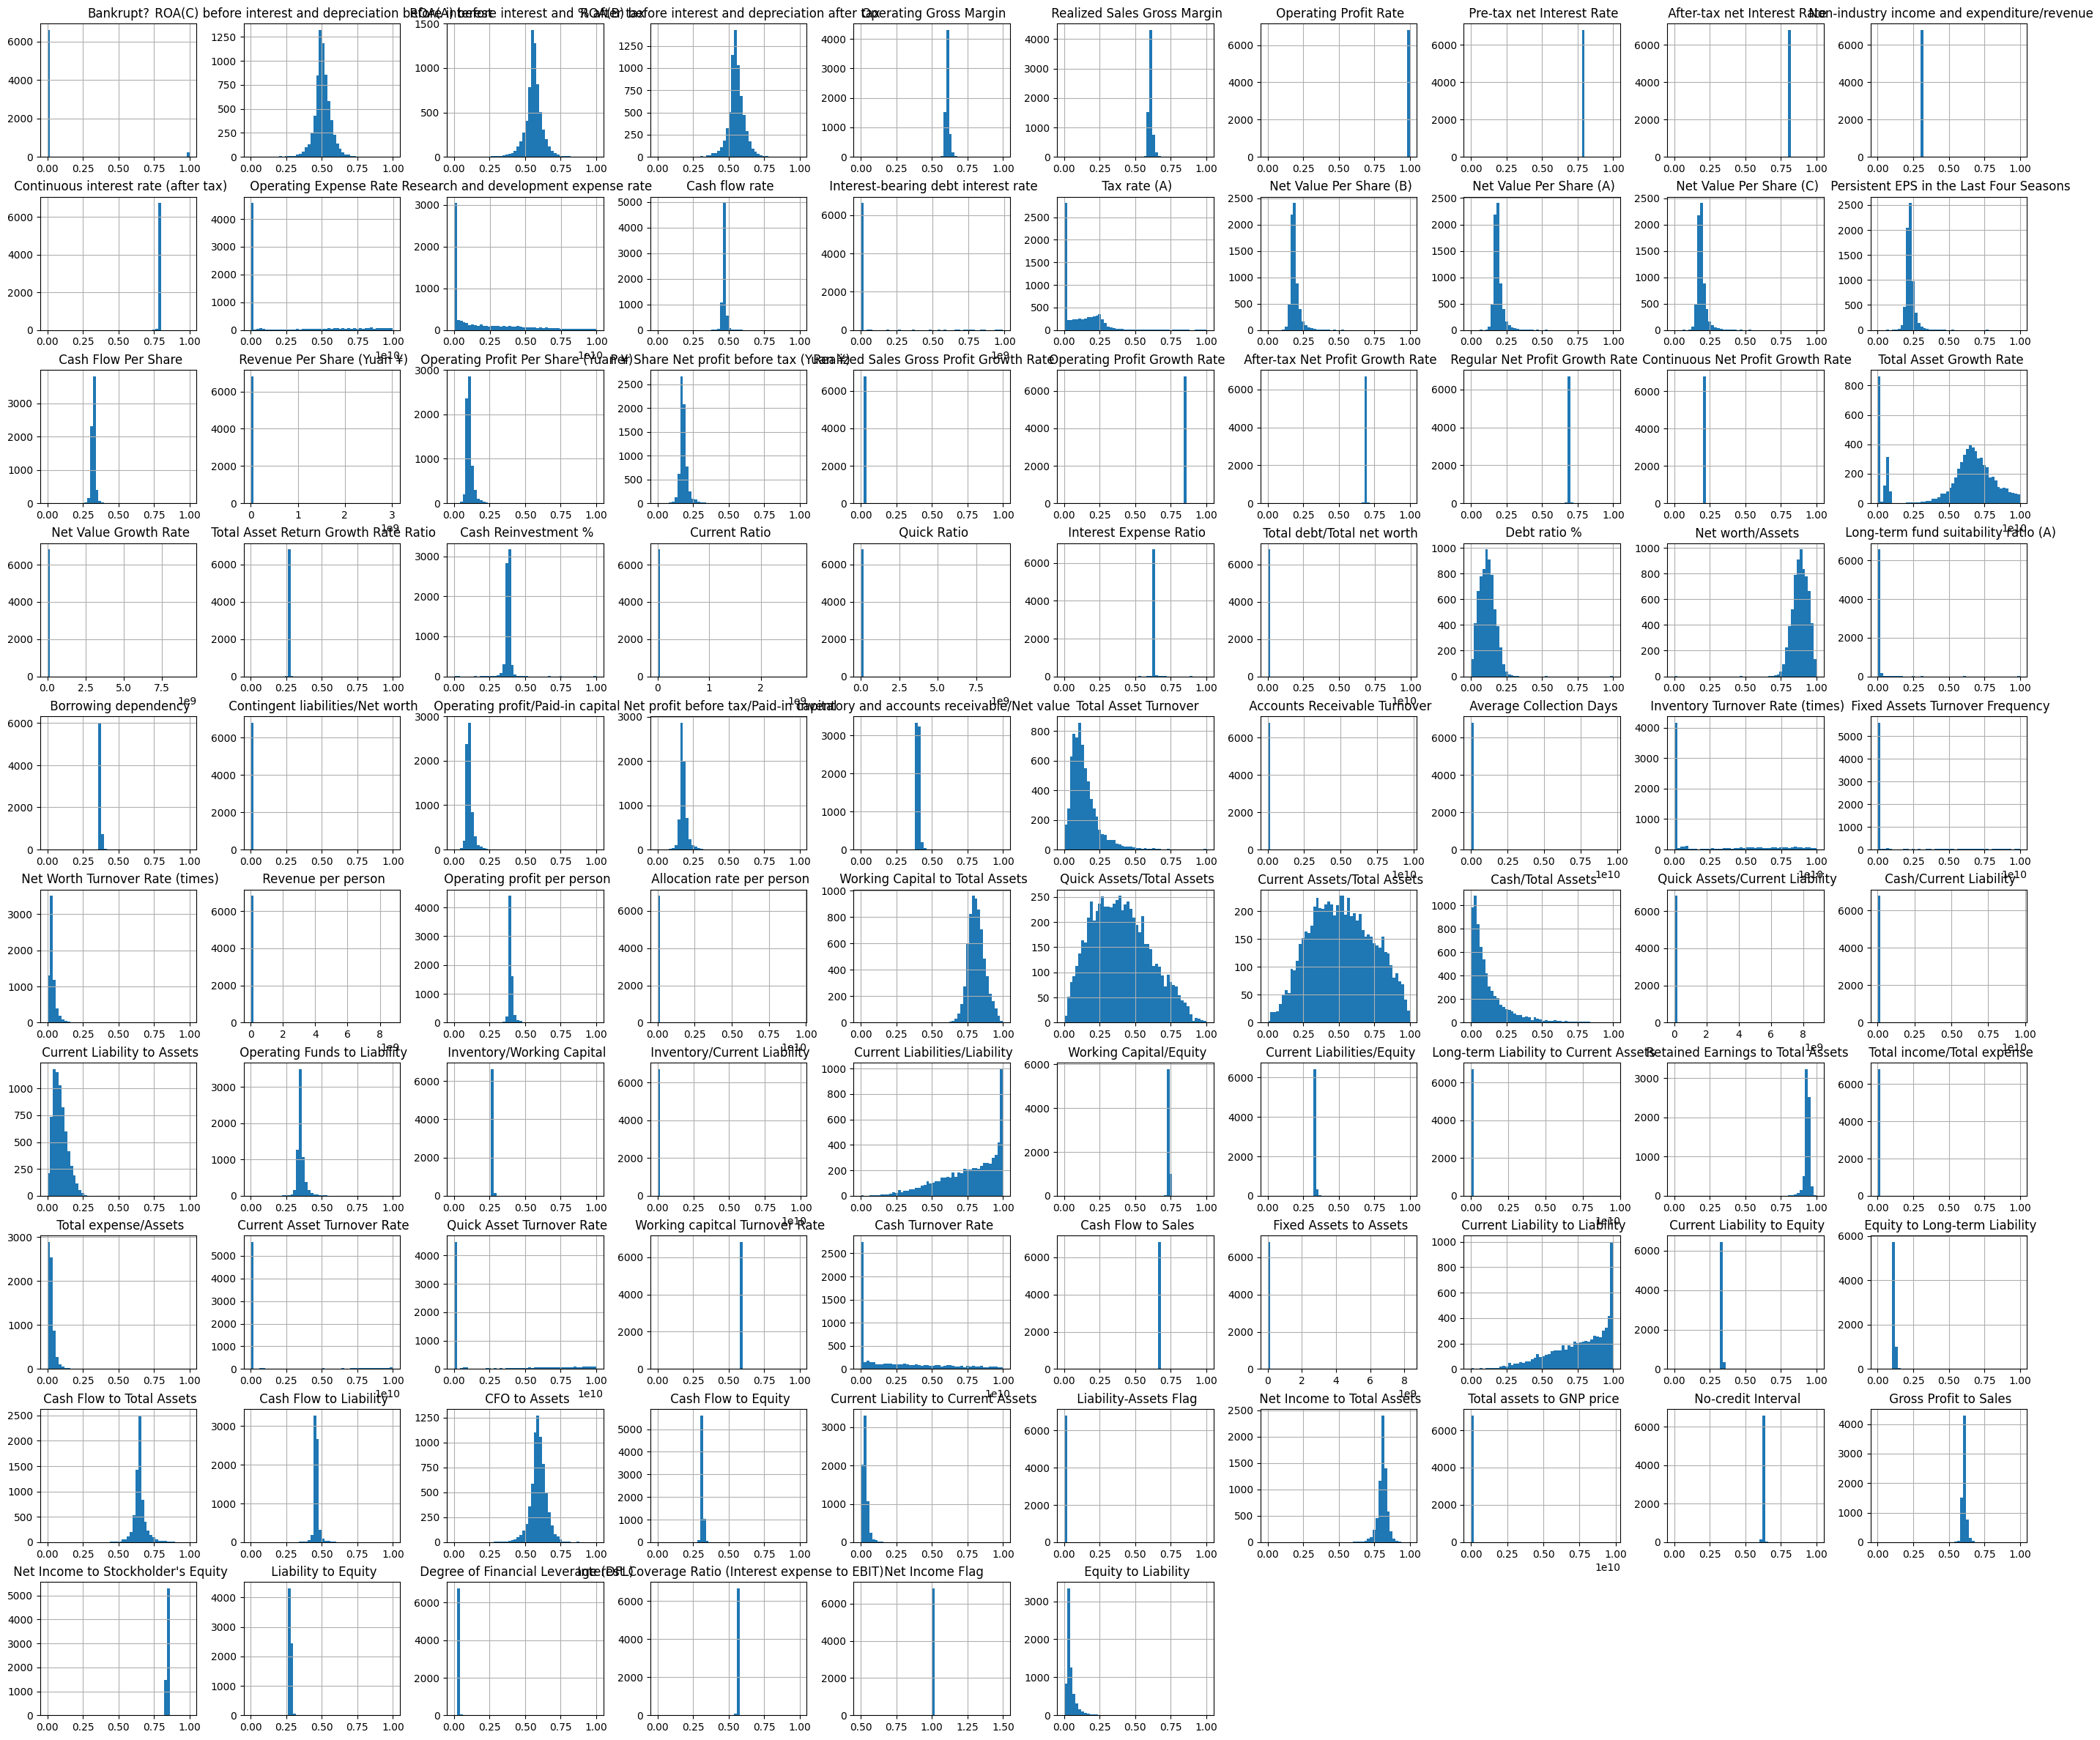

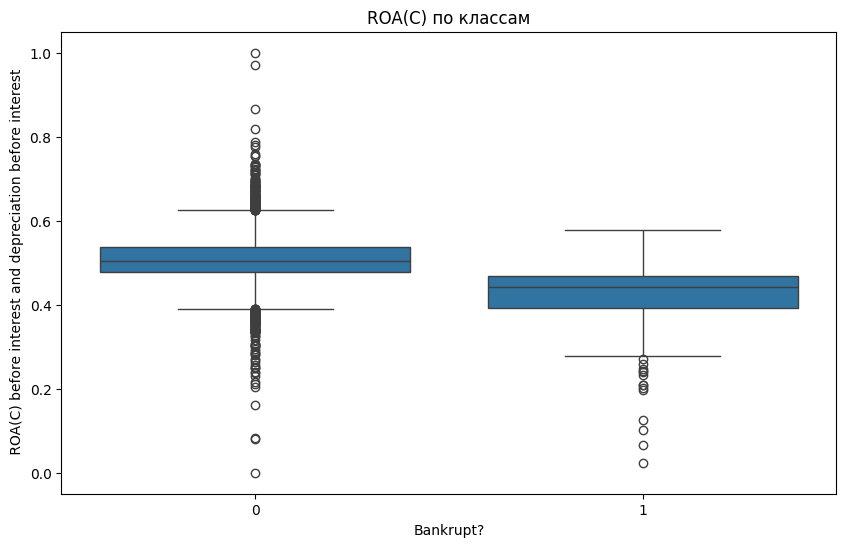

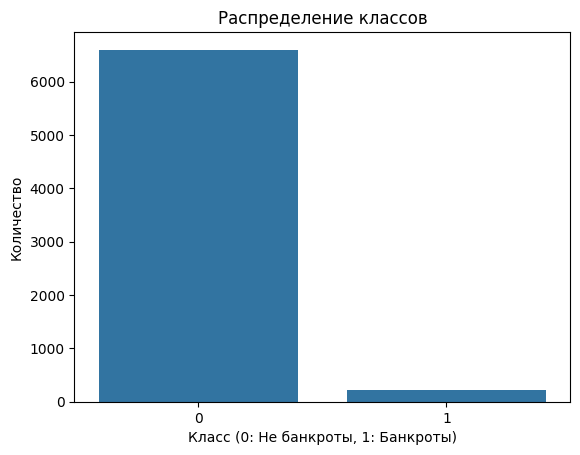

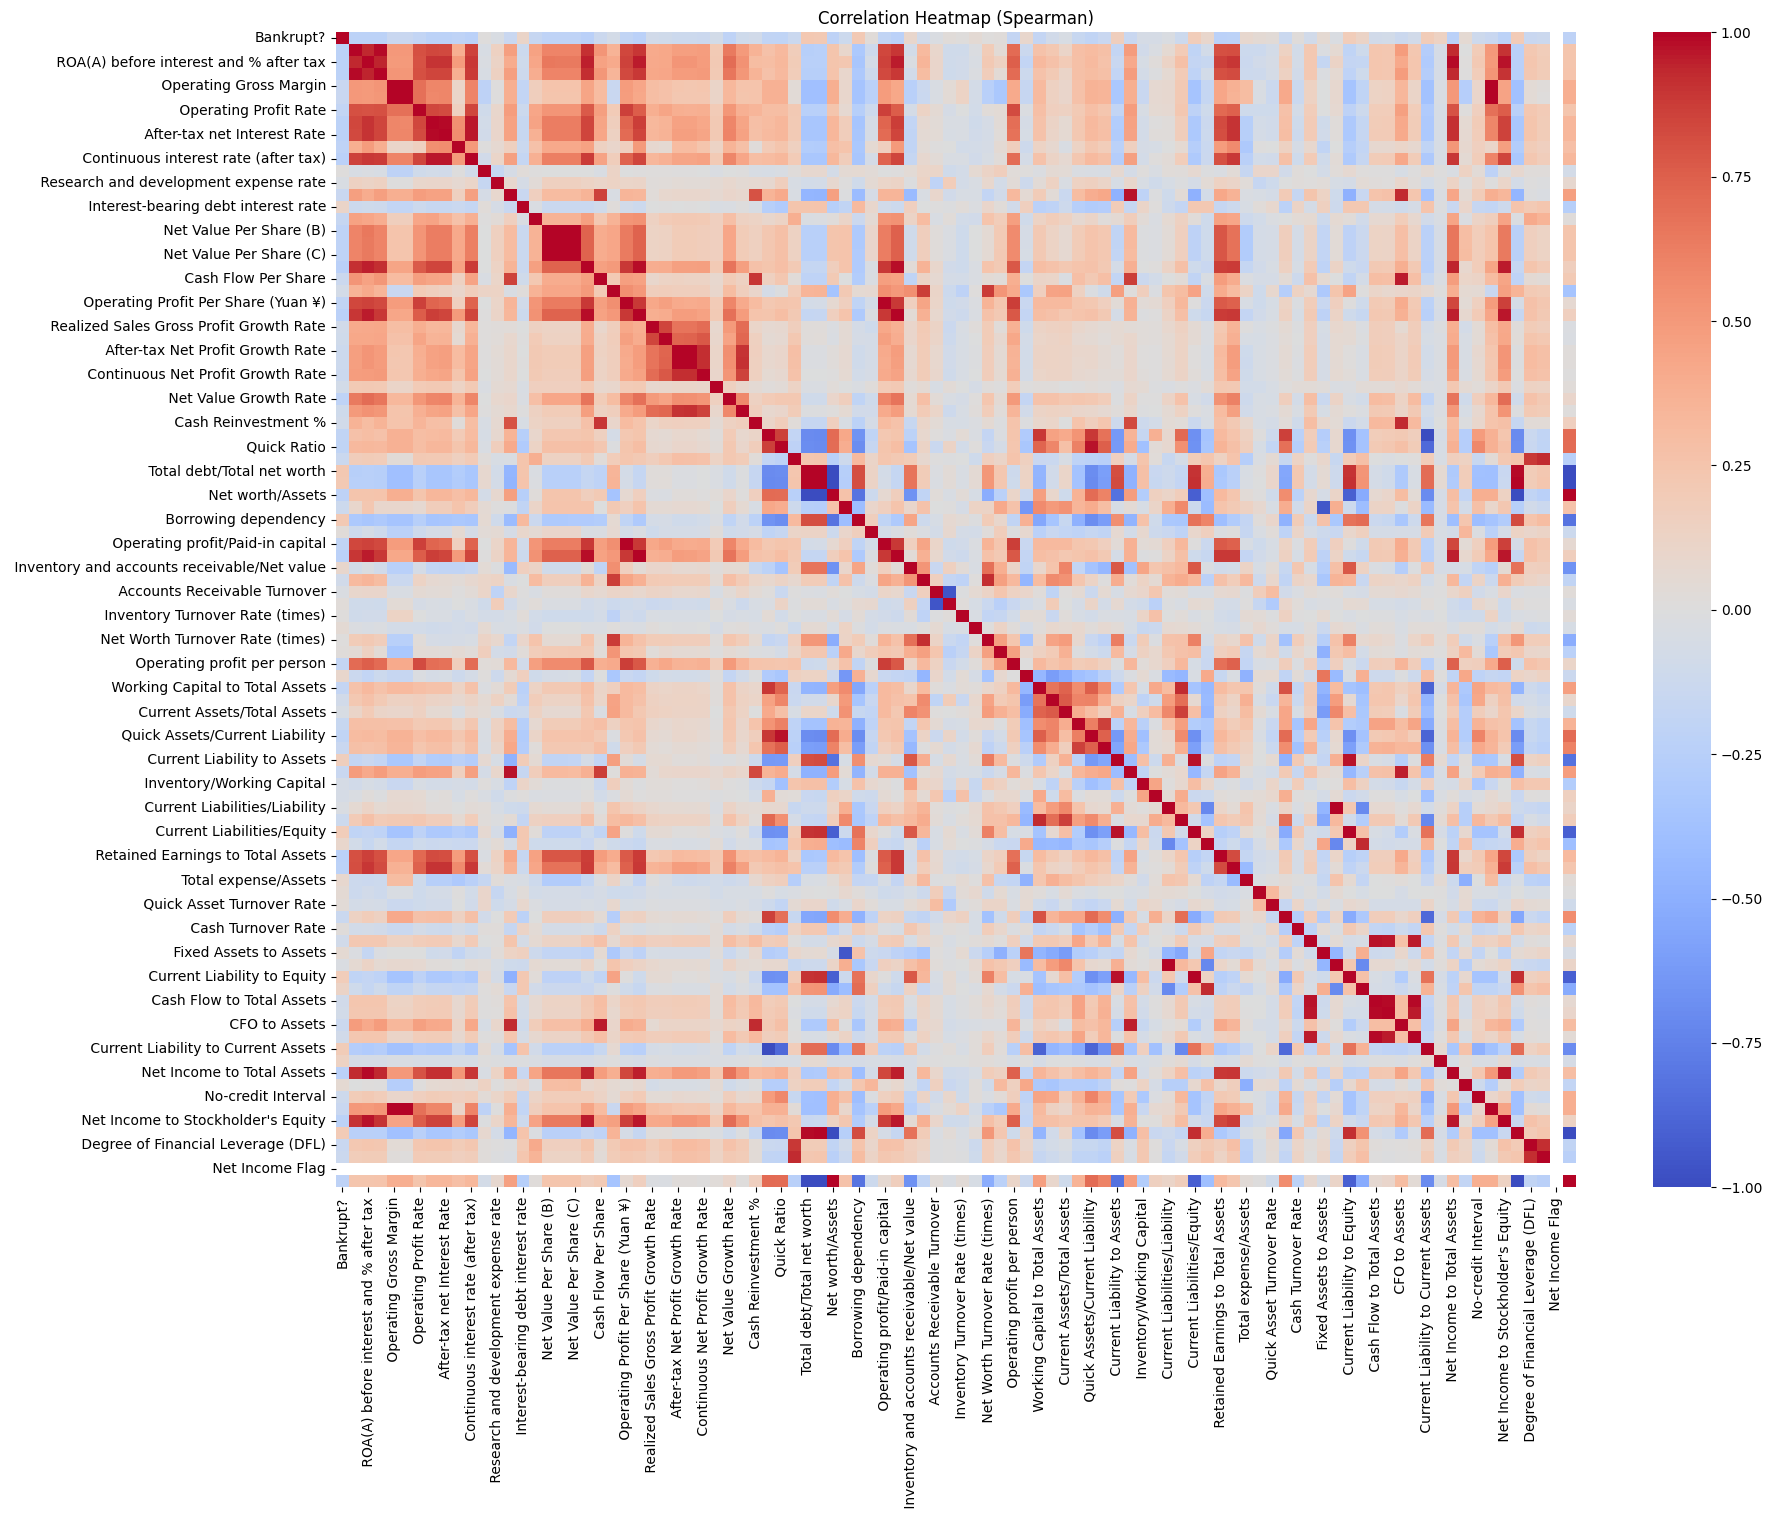

Столбцы с NaN:
------------------------------
Количество дубликатов: 0
Количество выбросов по признакам:
Bankrupt?                                                   220
 ROA(C) before interest and depreciation before interest     88
 ROA(A) before interest and % after tax                     110
 ROA(B) before interest and depreciation after tax          101
 Operating Gross Margin                                      63
                                                           ... 
 Net Income to Stockholder's Equity                          27
 Liability to Equity                                         28
 Degree of Financial Leverage (DFL)                          12
 Interest Coverage Ratio (Interest expense to EBIT)          36
 Equity to Liability                                        106
Length: 88, dtype: int64


In [ ]:
# Анализ распределения классов
print('Распределение классов:')
print(df['Bankrupt?'].value_counts())
print('-' * 30)
print('Финансово стабильные: ', round(df['Bankrupt?'].value_counts()[0] / len(df) * 100, 2), '% датасета')
print('Финансово нестабильные: ', round(df['Bankrupt?'].value_counts()[1] / len(df) * 100, 2), '% датасета')

# Гистограммы числовых признаков
df.hist(figsize=(35, 30), bins=50)
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='Bankrupt?', y=' ROA(C) before interest and depreciation before interest', data=df)
plt.title('ROA(C) по классам')
plt.show()

sns.countplot(x='Bankrupt?', data=df)
plt.title('Распределение классов')
plt.xlabel('Класс (0: Не банкроты, 1: Банкроты)')
plt.ylabel('Количество')
plt.show()

# Корреляционная матрица (Spearman)
plt.figure(figsize=(20, 15))
corr_matrix = df.corr(method='spearman')
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap (Spearman)')
plt.show()

# Проверка пропущенных значений
print("Столбцы с NaN:")
[print(col) for col in df if df[col].isna().sum() > 0]
print("-"*30)

print('Количество дубликатов:', df.duplicated().sum())

# Обнаружение выбросов (z-score)
numeric_columns = df.select_dtypes(include=[np.number]).columns
outliers = df[numeric_columns].apply(lambda x: np.abs(zscore(x)) > 3).sum()
print('Количество выбросов по признакам:')
print(outliers[outliers > 0])

## 4. Обнаружение и удаление константных признаков

In [ ]:
# Удаление константных признаков
def remove_constant_features(X):
    constant_features = [col for col in X.columns if X[col].nunique() <= 1]
    print(f"Удалены константные признаки: {constant_features}")
    return X.drop(columns=constant_features), constant_features

X_train, constant_features = remove_constant_features(X_train)
X_test = X_test.drop(columns=constant_features)

Удалены константные признаки: [' Net Income Flag']


## 5 Удаление выбросов (метод Z-score)

In [ ]:
def remove_outliers_zscore(X, y, threshold=3):
    """
    Удаляет выбросы из данных с использованием метода Z-score.

    Parameters:
    X (pd.DataFrame): Признаки.
    y (pd.Series): Целевая переменная.
    threshold (float): Порог стандартных отклонений.

    Returns:
    tuple: (DataFrame без выбросов, Series без выбросов, количество удаленных строк).
    """
    X_copy = X.copy()
    y_copy = y.copy()
    numeric_cols = X_copy.select_dtypes(include=[np.number]).columns.tolist()
    z_scores = np.abs(zscore(X_copy[numeric_cols]))
    mask = (z_scores < threshold).all(axis=1)

    X_no_outliers = X_copy[mask]
    y_no_outliers = y_copy[mask]
    removed_rows = len(X_copy) - len(X_no_outliers)
    print(f"Удалено строк с выбросами (Z-score): {removed_rows}")
    return X_no_outliers, y_no_outliers, removed_rows

X_train, y_train, _ = remove_outliers_zscore(X_train, y_train)
X_test, y_test, _ = remove_outliers_zscore(X_test, y_test)

Удалено строк с выбросами (Z-score): 1528
Удалено строк с выбросами (Z-score): 405


## 6. Feature Engineering

In [181]:
def create_features(X):
    X_new = X.copy()
    
    required_cols = [
        ' Net Income to Total Assets',
        ' ROA(C) before interest and depreciation before interest',
        ' Liability to Equity'
    ]
    available_cols = X.columns.tolist()
    missing_cols = [col for col in required_cols if col not in available_cols]
    if missing_cols:
        raise KeyError(f"Отсутствуют столбцы: {missing_cols}")
    print(f"Доступные столбцы: {available_cols}")

    
    for col in [' Net Income to Total Assets', ' ROA(C) before interest and depreciation before interest']:
        X_new[f'Log_{col}'] = np.log1p(X_new[col].clip(lower=0))  
        X_new[f'Square_{col}'] = X_new[col] ** 2 
    
    X_new['Profit_to_Debt'] = X_new[' Net Income to Total Assets'] / (X_new[' Liability to Equity'].clip(lower=1e-6, upper=1e6) + 1e-6)
    
    new_features = [
        'Log_ Net Income to Total Assets', 'Square_ Net Income to Total Assets',
        'Log_ ROA(C) before interest and depreciation before interest',
        'Square_ ROA(C) before interest and depreciation before interest',
        'Profit_to_Debt'
    ]
    # if X_new[new_features].isna().any().any() or np.isinf(X_new[new_features]).any().any():
    #     print("Созданные признаки содержат NaN или inf. Заменяем на 0.")
    #     X_new[new_features] = X_new[new_features].replace([np.inf, -np.inf], 0).fillna(0)
    
    print(f"Создано новых признаков: {list(X_new.columns.difference(X.columns))}")
    return X_new

X_train = create_features(X_train)
X_test = create_features(X_test)

# Синхронизация индексов
y_train = y_train.loc[X_train.index]
y_test = y_test.loc[X_test.index]



Доступные столбцы: [' ROA(C) before interest and depreciation before interest', ' ROA(A) before interest and % after tax', ' ROA(B) before interest and depreciation after tax', ' Operating Gross Margin', ' Realized Sales Gross Margin', ' Operating Profit Rate', ' Pre-tax net Interest Rate', ' After-tax net Interest Rate', ' Non-industry income and expenditure/revenue', ' Continuous interest rate (after tax)', ' Operating Expense Rate', ' Research and development expense rate', ' Cash flow rate', ' Interest-bearing debt interest rate', ' Tax rate (A)', ' Net Value Per Share (B)', ' Net Value Per Share (A)', ' Net Value Per Share (C)', ' Persistent EPS in the Last Four Seasons', ' Cash Flow Per Share', ' Revenue Per Share (Yuan ¥)', ' Operating Profit Per Share (Yuan ¥)', ' Per Share Net profit before tax (Yuan ¥)', ' Realized Sales Gross Profit Growth Rate', ' Operating Profit Growth Rate', ' After-tax Net Profit Growth Rate', ' Regular Net Profit Growth Rate', ' Continuous Net Profit G

## 7.1. Стандартные модели

In [182]:
models = {
    'Logistic Regression': Pipeline([
        ('scaler', StandardScaler()),
        ('feature_selection', SelectKBest(f_classif, k=20)),
        ('classifier', LogisticRegression(random_state=42))
    ]),
    'Random Forest': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', RandomForestClassifier(random_state=42, n_estimators=100))
    ]),
    'XGBoost': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', XGBClassifier(random_state=42, eval_metric='logloss'))
    ]),
    'SVM': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', SVC(random_state=42, probability=True))
    ])
}

## 7.2. Модифицированые модели

In [176]:
models = {}

# Улучшенная Logistic Regression с SMOTE и GridSearchCV
lr = LogisticRegression()
lr_params = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs', 'saga'],
    'class_weight': [None, 'balanced'],
    'random_state': [42]
}
grid_lr = GridSearchCV(lr, lr_params, scoring='f1', cv=2, n_jobs=-1)
lr_pipeline = imbalanced_make_pipeline(
    SMOTE(sampling_strategy='minority', random_state=42),
    StandardScaler(),
    SelectKBest(f_classif, k=20),
    grid_lr
)
models['Logistic Regression (SMOTE + Tuned)'] = lr_pipeline

# Улучшенный SVM с SMOTE и RandomizedSearchCV
svm = SVC(probability=True)
svm_params = {
    'C': [0.1, 1, 10, 20],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto', 0.01, 0.1],
    'random_state': [42]
}
rand_svm = RandomizedSearchCV(svm, svm_params, n_iter=5, scoring='f1', cv=2, random_state=42, n_jobs=-1)
svm_pipeline = imbalanced_make_pipeline(
    SMOTE(sampling_strategy=0.5, random_state=42),
    StandardScaler(),
    rand_svm
)
models['SVM (SMOTE + Tuned)'] = svm_pipeline

# Улучшенный Random Forest с SMOTE и RandomizedSearchCV
rfc_sm = RandomForestClassifier()
rfc_params = {
    'max_features': ['sqrt', 'log2'],
    'random_state': [42],
    'class_weight': ['balanced', 'balanced_subsample'],
    'criterion': ['gini', 'entropy'],
    'bootstrap': [True, False],
    'n_estimators': [100, 200],
    'max_depth': [10, 20]
}
rand_rfc = RandomizedSearchCV(rfc_sm, rfc_params, n_iter=5, scoring='f1', cv=2, random_state=42, n_jobs=-1)
rf_pipeline = imbalanced_make_pipeline(
    SMOTE(sampling_strategy=0.5, random_state=42),
    StandardScaler(),
    rand_rfc
)
models['Random Forest (SMOTE + Tuned)'] = rf_pipeline

# Улучшенный XGBoost с SMOTE и RandomizedSearchCV
xgb_sm = XGBClassifier(eval_metric='logloss')
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
xgb_params = {
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 6],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'scale_pos_weight': [1, scale_pos_weight]
}
rand_xgb = RandomizedSearchCV(xgb_sm, xgb_params, n_iter=5, scoring='f1', cv=2, random_state=42, n_jobs=-1)
xgb_pipeline = imbalanced_make_pipeline(
    SMOTE(sampling_strategy=0.5, random_state=42),
    StandardScaler(),
    rand_xgb
)
models['XGBoost (SMOTE + Tuned)'] = xgb_pipeline

## 8. Обучение и оценка моделей

Training on original data (after removing constant features):
Обучение модели: Logistic Regression

Logistic Regression Confusion Matrix:
[[927   5]
 [ 25   2]]

Logistic Regression Results:
              precision    recall  f1-score   support

           0    0.97374   0.99464   0.98408       932
           1    0.28571   0.07407   0.11765        27

    accuracy                        0.96872       959
   macro avg    0.62973   0.53435   0.55086       959
weighted avg    0.95437   0.96872   0.95968       959

Время обучения (fit): 0.05 секунд
Общее время (fit + predict + metrics): 0.07 секунд
Обучение модели: Random Forest


C:\Users\maksc\AppData\Roaming\Python\Python312\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [84] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\maksc\AppData\Roaming\Python\Python312\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw



Random Forest Confusion Matrix:
[[931   1]
 [ 25   2]]

Random Forest Results:
              precision    recall  f1-score   support

           0    0.97385   0.99893   0.98623       932
           1    0.66667   0.07407   0.13333        27

    accuracy                        0.97289       959
   macro avg    0.82026   0.53650   0.55978       959
weighted avg    0.96520   0.97289   0.96222       959

Время обучения (fit): 1.86 секунд
Общее время (fit + predict + metrics): 1.88 секунд
Обучение модели: XGBoost

XGBoost Confusion Matrix:
[[929   3]
 [ 18   9]]

XGBoost Results:
              precision    recall  f1-score   support

           0    0.98099   0.99678   0.98882       932
           1    0.75000   0.33333   0.46154        27

    accuracy                        0.97810       959
   macro avg    0.86550   0.66506   0.72518       959
weighted avg    0.97449   0.97810   0.97398       959

Время обучения (fit): 0.35 секунд
Общее время (fit + predict + metrics): 0.36 секунд
Обу

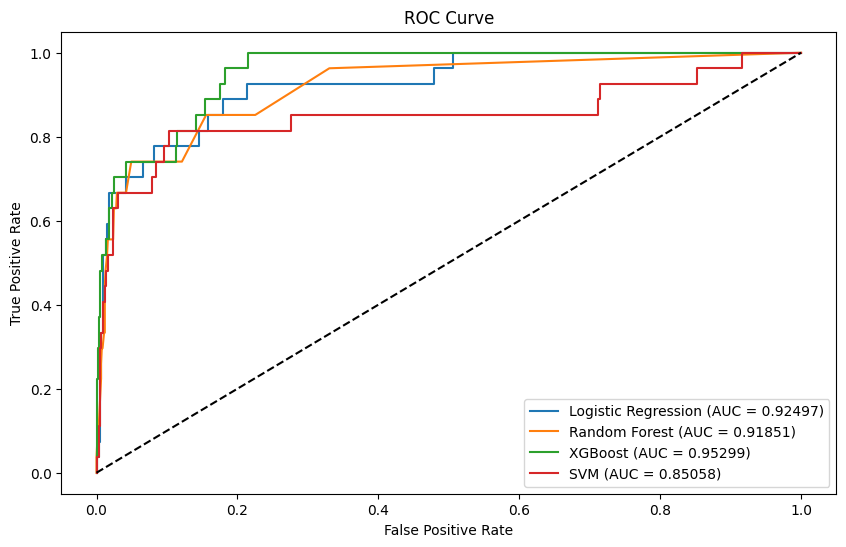

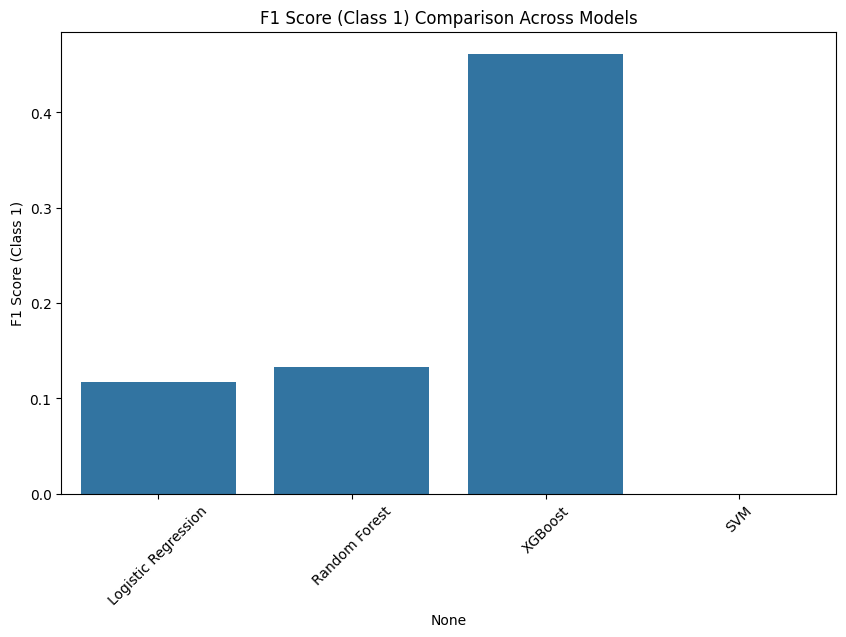


Summary of Results:
                    Accuracy F1 Score (Class 1)  ROC AUC Fit Time (s)  \
Logistic Regression  0.96872            0.11765  0.92497         0.05   
Random Forest        0.97289            0.13333  0.91851         1.86   
XGBoost              0.97810            0.46154  0.95299         0.35   
SVM                  0.97185            0.00000  0.85058         0.84   

                    Total Time (s)  
Logistic Regression           0.07  
Random Forest                 1.88  
XGBoost                       0.36  
SVM                           0.97  


In [183]:
def train_and_evaluate(models, X_train, X_test, y_train, y_test):
    results = {}
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    plt.figure(figsize=(10, 6))

    for name, model in models.items():
        print(f"Обучение модели: {name}")
        
        start_total_time = time.time()
        start_fit_time = time.time()
        model.fit(X_train, y_train)
        end_fit_time = time.time()
        fit_time = end_fit_time - start_fit_time
        
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else model.decision_function(X_test)
        
        f1_1 = f1_score(y_test, y_pred, labels=[1], zero_division=0)
        accuracy = accuracy_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba)

        cm = confusion_matrix(y_test, y_pred)
        print(f"\n{name} Confusion Matrix:\n{cm}")
        
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc_val = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc_val:.5f})')
        
        end_total_time = time.time()
        total_time = end_total_time - start_total_time
        
        results[name] = {
            'Accuracy': f'{accuracy:.5f}',
            'F1 Score (Class 1)': f'{f1_1:.5f}',
            'ROC AUC': f'{roc_auc:.5f}',
            'Fit Time (s)': f'{fit_time:.2f}',
            'Total Time (s)': f'{total_time:.2f}'
        }
        
        print(f"\n{name} Results:\n{classification_report(y_test, y_pred, zero_division=0, digits=5)}")
        print(f"Время обучения (fit): {fit_time:.2f} секунд")
        print(f"Общее время (fit + predict + metrics): {total_time:.2f} секунд")
        
        # Вывод лучших параметров 
        search_step = None
        if 'gridsearchcv' in model.named_steps:
            search_step = 'gridsearchcv'
        elif 'randomizedsearchcv' in model.named_steps:
            search_step = 'randomizedsearchcv'
        
        if search_step:
            best_params = model.named_steps[search_step].best_params_
            print(f"\n{name} Best Parameters:")
            for param, value in best_params.items():
                print(f"{param}: {value}")
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()
    
    results_df = pd.DataFrame(results).T
  
    # Визуализация F1 Score для класса 1
    plt.figure(figsize=(10, 6))
    sns.barplot(x=results_df.index, y=results_df['F1 Score (Class 1)'].astype(float))
    plt.title('F1 Score (Class 1) Comparison Across Models')
    plt.xticks(rotation=45)
    plt.ylabel('F1 Score (Class 1)')
    plt.show()
    
    print('\nSummary of Results:')
    print(results_df)
    
    return results

# X_train = create_features(X_train)
# X_test = create_features(X_test)
# y_train = y_train.loc[X_train.index]
# y_test = y_test.loc[X_test.index]

# X_train = X_train.reset_index(drop=True)
# y_train = y_train.reset_index(drop=True)
# X_test = X_test.reset_index(drop=True)
# y_test = y_test.reset_index(drop=True)

# X_train, y_train, removed_train = remove_outliers_zscore(X_train, y_train, threshold=1.5)
# X_test, y_test, removed_test = remove_outliers_zscore(X_test, y_test, threshold=1.5)

# X_train, constant_features = remove_constant_features(X_train)
# X_test = X_test.drop(columns=constant_features)

# Обучение и оценка моделей
print('Training on original data (after removing constant features):')
results_original = train_and_evaluate(models, X_train, X_test, y_train, y_test)

# Анализ производительности моделей и выбор лучшей модели

## 1. Введение

Цель анализа — оценка четырех моделей машинного обучения (`Logistic Regression`, `SVM`, `Random Forest`, `XGBoost`) для предсказания банкротства компаний на основе финансовых данных. Датасет содержит 6819 записей с 96 признаками, где **класс 1 (банкроты)** составляет ~3.23%, а **класс 0 (не банкроты)** — ~96.77%, что делает задачу несбалансированной. Основной приоритет — максимизация **F1 Score для класса 1 (банкроты)**, так как пропуск банкротов (ложноотрицательные ошибки) критичен. Однако производительность для класса 0 (не банкроты) также важна для общей надежности модели.

Для улучшения качества предсказаний применялись:
- **SMOTE**: Балансировка классов в модифицированных сценариях.
- **Feature Engineering (FE)**: Создание новых признаков.
- **Z-score удаление выбросов**: Уменьшение шума в данных.
- **Тюнинг гиперпараметров**: Использование `GridSearchCV` или `RandomizedSearchCV`.

Модели тестировались в пяти сценариях:
1. Модифицированные модели с Z-score удалением выбросов и Feature Engineering (959 строк: 932 класса 0, 27 класса 1).
2. Модифицированные модели с Z-score удалением выбросов без Feature Engineering (959 строк).
3. Модифицированные модели без Z-score удаления выбросов и без Feature Engineering (1364 строки: 1320 класса 0, 44 класса 1).
4. Стандартные модели без Z-score удаления выбросов и без Feature Engineering (1364 строк).
5. Стандартные модели с Z-score удалением выбросов и Feature Engineering (959 строк).

**Ключевые метрики**:
- **F1 Score (Class 1)**: Основная метрика для банкротов.
- **F1 Score (Class 0)**: Для оценки производительности на не банкротах.
- **Precision и Recall**: Для анализа ошибок обоих классов.
- **Accuracy**: Общая точность (менее приоритетна из-за несбалансированности).
- **Fit Time**: Время обучения для оценки вычислительной эффективности.

## 2. Анализ результатов

### 2.1. Сценарий 1: Модифицированные модели с Z-score удалением выбросов и Feature Engineering
- **Тестовый набор**: 959 строк (932 класса 0, 27 класса 1).
- **Предобработка**: Z-score, Feature Engineering, SMOTE, тюнинг гиперпараметров.
- **Результаты**:
  - **Logistic Regression**:
    - **Class 1 (банкроты)**: F1 = 0.29577, Precision = 0.18261, Recall = 0.77778.
    - **Class 0 (не банкроты)**: F1 = 0.94369, Precision = 0.99289, Recall = 0.89914.
    - Accuracy: 0.89572.
    - Fit Time: 0.86 с.
  - **SVM**:
    - **Class 1**: F1 = 0.25641, Precision = 0.41667, Recall = 0.18519.
    - **Class 0**: F1 = 0.98457, Precision = 0.97677, Recall = 0.99249.
    - Accuracy: 0.96976.
    - Fit Time: 47.44 с.
  - **Random Forest**:
    - **Class 1**: F1 = 0.46154, Precision = 0.48000, Recall = 0.44444.
    - **Class 0**: F1 = 0.98499, Precision = 0.98394, Recall = 0.98605.
    - Accuracy: 0.97080.
    - Fit Time: 12.27 с.
  - **XGBoost**:
    - **Class 1**: F1 = **0.54545**, Precision = 0.53571, Recall = 0.55556.
    - **Class 0**: F1 = 0.98658, Precision = 0.98711, Recall = 0.98605.
    - Accuracy: 0.97393.
    - Fit Time: 5.17 с.
- **Наблюдения**:
  - `XGBoost` лидирует по F1 Score для класса 1 (0.54545) и имеет высокий F1 для класса 0 (0.98658).
  - `Logistic Regression` показывает высокий recall для класса 1 (0.77778), но низкую точность (0.18261), что увеличивает ложноположительные ошибки (FP = 94).
  - `SVM` плохо справляется с классом 1 (низкий recall 0.18519), но эффективна для класса 0 (F1 = 0.98457).
  - `Random Forest` конкурентоспособен для обоих классов, но уступает `XGBoost`.

### 2.2. Сценарий 2: Модифицированные модели с Z-score удалением выбросов без Feature Engineering
- **Тестовый набор**: 959 строк (932 класса 0, 27 класса 1).
- **Предобработка**: Z-score, SMOTE, тюнинг гиперпараметров.
- **Результаты**:
  - **Logistic Regression**:
    - **Class 1**: F1 = 0.30435, Precision = 0.18919, Recall = 0.77778.
    - **Class 0**: F1 = 0.94607, Precision = 0.99292, Recall = 0.90343.
    - Accuracy: 0.89990.
    - Fit Time: 3.47 с.
  - **SVM**:
    - **Class 1**: F1 = 0.25000, Precision = 0.38462, Recall = 0.18519.
    - **Class 0**: F1 = 0.98403, Precision = 0.97674, Recall = 0.99142.
    - Accuracy: 0.96872.
    - Fit Time: 38.63 с.
  - **Random Forest**:
    - **Class 1**: F1 = 0.47059, Precision = 0.50000, Recall = 0.44444.
    - **Class 0**: F1 = 0.98554, Precision = 0.98396, Recall = 0.98712.
    - Accuracy: 0.97185.
    - Fit Time: 11.32 с.
  - **XGBoost**:
    - **Class 1**: F1 = **0.54545**, Precision = 0.53571, Recall = 0.55556.
    - **Class 0**: F1 = 0.98658, Precision = 0.98711, Recall = 0.98605.
    - Accuracy: 0.97393.
    - Fit Time: 4.03 с.
- **Наблюдения**:
  - `XGBoost` сохраняет лидерство (F1 Class 1 = 0.54545, F1 Class 0 = 0.98658), идентичное сценарию 1.
  - Отсутствие Feature Engineering не влияет на `XGBoost`, что подтверждает устойчивость модели.
  - `Random Forest` улучшает F1 для класса 1 (0.47059 vs 0.46154), но остается позади `XGBoost`.
  - `SVM` и `Logistic Regression` слабые для класса 1, но хороши для класса 0.

### 2.3. Сценарий 3: Модифицированные модели без Z-score удаления выбросов и без Feature Engineering
- **Тестовый набор**: 1364 строки (1320 класса 0, 44 класса 1).
- **Предобработка**: SMOTE, тюнинг гиперпараметров.
- **Результаты**:
  - **Logistic Regression**:
    - **Class 1**: F1 = 0.33484, Precision = 0.20904, Recall = 0.84091.
    - **Class 0**: F1 = 0.94136, Precision = 0.99410, Recall = 0.89394.
    - Accuracy: 0.89223.
    - Fit Time: 1.01 с.
  - **SVM**:
    - **Class 1**: F1 = 0.45833, Precision = 0.42308, Recall = 0.50000.
    - **Class 0**: F1 = 0.98024, Precision = 0.98323, Recall = 0.97727.
    - Accuracy: 0.96188.
    - Fit Time: 45.61 с.
  - **Random Forest**:
    - **Class 1**: F1 = 0.50000, Precision = 0.46154, Recall = 0.54545.
    - **Class 0**: F1 = 0.98176, Precision = 0.98476, Recall = 0.97879.
    - Accuracy: 0.96481.
    - Fit Time: 15.15 с.
  - **XGBoost**:
    - **Class 1**: F1 = **0.50549**, Precision = 0.48936, Recall = 0.52273.
    - **Class 0**: F1 = 0.98294, Precision = 0.98405, Recall = 0.98182.
    - Accuracy: 0.96701.
    - Fit Time: 5.43 с.
- **Наблюдения**:
  - `XGBoost` лидирует по F1 для класса 1 (0.50549), но результат ниже, чем в сценариях 1 и 2.
  - `Random Forest` близок к `XGBoost` (F1 Class 1 = 0.50000) и эффективен для класса 0 (F1 = 0.98176).
  - Увеличенный тестовый набор (1364 строк) улучшает F1 для класса 1 у `Random Forest` и `SVM`.
  - `Logistic Regression` имеет высокий recall для класса 1 (0.84091), но низкую точность (0.20904).

### 2.4. Сценарий 4: Стандартные модели без Z-score удаления выбросов и без Feature Engineering
- **Тестовый набор**: 1364 строки (1320 класса 0, 44 класса 1).
- **Предобработка**: Нет SMOTE, нет тюнинга.
- **Результаты**:
  - **Logistic Regression**:
    - **Class 1**: F1 = 0.30508, Precision = 0.60000, Recall = 0.20455.
    - **Class 0**: F1 = 0.98464, Precision = 0.97405, Recall = 0.99545.
    - Accuracy: 0.96994.
    - Fit Time: 0.07 с.
  - **SVM**:
    - **Class 1**: F1 = 0.00000, Precision = 0.00000, Recall = 0.00000.
    - **Class 0**: F1 = 0.98361, Precision = 0.96774, Recall = 1.00000.
    - Accuracy: 0.96774.
    - Fit Time: 2.15 с.
  - **Random Forest**:
    - **Class 1**: F1 = 0.29508, Precision = 0.52941, Recall = 0.20455.
    - **Class 0**: F1 = 0.98388, Precision = 0.97402, Recall = 0.99394.
    - Accuracy: 0.96848.
    - Fit Time: 2.62 с.
  - **XGBoost**:
    - **Class 1**: F1 = **0.40580**, Precision = 0.56000, Recall = 0.31818.
    - **Class 0**: F1 = 0.98458, Precision = 0.97760, Recall = 0.99167.
    - Accuracy: 0.96994.
    - Fit Time: 0.49 с.
- **Наблюдения**:
  - `XGBoost` лучший для класса 1 (F1 = 0.40580), но результат хуже, чем в модифицированных сценариях.
  - `SVM` не предсказывает банкротов (F1 Class 1 = 0.00000), но идеальна для класса 0 (Recall = 1.00000).
  - Без SMOTE и тюнинга F1 Score для класса 1 значительно ниже.
  - Все модели показывают высокие F1 для класса 0 (0.98361–0.98464).

### 2.5. Сценарий 5: Стандартные модели с Z-score удалением выбросов и Feature Engineering
- **Тестовый набор**: 959 строк (932 класса 0, 27 класса 1).
- **Предобработка**: Z-score, Feature Engineering, без SMOTE, без тюнинга.
- **Результаты**:
  - **Logistic Regression**:
    - **Class 1**: F1 = 0.11765, Precision = 0.28571, Recall = 0.07407.
    - **Class 0**: F1 = 0.98408, Precision = 0.97374, Recall = 0.99464.
    - Accuracy: 0.96872.
    - Fit Time: 0.05 с.
  - **SVM**:
    - **Class 1**: F1 = 0.00000, Precision = 0.00000, Recall = 0.00000.
    - **Class 0**: F1 = 0.98572, Precision = 0.97185, Recall = 1.00000.
    - Accuracy: 0.97185.
    - Fit Time: 0.84 с.
  - **Random Forest**:
    - **Class 1**: F1 = 0.13333, Precision = 0.66667, Recall = 0.07407.
    - **Class 0**: F1 = 0.98623, Precision = 0.97385, Recall = 0.99893.
    - Accuracy: 0.97289.
    - Fit Time: 1.86 с.
  - **XGBoost**:
    - **Class 1**: F1 = **0.46154**, Precision = 0.75000, Recall = 0.33333.
    - **Class 0**: F1 = 0.98882, Precision = 0.98099, Recall = 0.99678.
    - Accuracy: 0.97810.
    - Fit Time: 0.35 с.
- **Наблюдения**:
  - `XGBoost` лидирует для класса 1 (F1 = 0.46154) и показывает лучший F1 для класса 0 (0.98882).
  - Без SMOTE все модели имеют низкий recall для класса 1, пропуская большинство банкротов.
  - `SVM` не предсказывает класс 1, но идеальна для класса 0 (Recall = 1.00000).
  - Z-score и Feature Engineering улучшают F1 для класса 0, но недостаточны для класса 1 без SMOTE.

## 3. Сравнение моделей

### 3.1. F1 Score для класса 1 (банкроты)
F1 Score для класса 1 — основная метрика из-за несбалансированности и важности выявления банкротов.

| Сценарий | Logistic Regression | SVM | Random Forest | XGBoost |
|----------|---------------------|-----|---------------|---------|
| 1 (Z-score + FE) | 0.29577 | 0.25641 | 0.46154 | **0.54545** |
| 2 (Z-score, no FE) | 0.30435 | 0.25000 | 0.47059 | **0.54545** |
| 3 (No Z-score, no FE) | 0.33484 | 0.45833 | 0.50000 | **0.50549** |
| 4 (Standard, no Z-score, no FE) | 0.30508 | 0.00000 | 0.29508 | **0.40580** |
| 5 (Standard, Z-score + FE) | 0.11765 | 0.00000 | 0.13333 | **0.46154** |

- **XGBoost** лидирует во всех сценариях (F1 = 0.40580–0.54545).
- **Random Forest** конкурентоспособен в модифицированных сценариях (0.46154–0.50000).
- **Logistic Regression** имеет умеренные результаты (0.11765–0.33484), но высокий recall в сценариях 1–3.
- **SVM** слабая, особенно в стандартных сценариях (F1 = 0.00000).

### 3.2. F1 Score для класса 0 (не банкроты)
F1 Score для класса 0 важен для общей надежности модели.

| Сценарий | Logistic Regression | SVM | Random Forest | XGBoost |
|----------|---------------------|-----|---------------|---------|
| 1 (Z-score + FE) | 0.94369 | 0.98457 | 0.98499 | 0.98658 |
| 2 (Z-score, no FE) | 0.94607 | 0.98403 | 0.98554 | 0.98658 |
| 3 (No Z-score, no FE) | 0.94136 | 0.98024 | 0.98176 | 0.98294 |
| 4 (Standard, no Z-score, no FE) | 0.98464 | 0.98361 | 0.98388 | 0.98458 |
| 5 (Standard, Z-score + FE) | 0.98408 | 0.98572 | 0.98623 | **0.98882** |

- **XGBoost** показывает лучшие или близкие к лучшим результаты (0.98294–0.98882).
- **Random Forest** и **SVM** также эффективны (0.98024–0.98623).
- **Logistic Regression** отстает в модифицированных сценариях (0.94136–0.94607), но конкурентоспособна в стандартных.

### 3.3. Precision и Recall для обоих классов
- **Класс 1 (банкроты)**:
  - `XGBoost` (Сценарий 1/2): Precision = 0.53571, Recall = 0.55556 — лучший баланс.
  - `Logistic Regression` (Сценарий 3): Recall = 0.84091, но Precision = 0.20904 (много FP).
  - `SVM` (Сценарий 5): Recall = 0.00000 (не находит банкротов).
  - `Random Forest` (Сценарий 3): Precision = 0.46154, Recall = 0.54545 — близко к `XGBoost`.
- **Класс 0 (не банкроты)**:
  - Все модели имеют высокие Precision (0.96774–0.99410) и Recall (0.89394–1.00000).
  - `XGBoost` (Сценарий 5): Precision = 0.98099, Recall = 0.99678 — почти идеально.
  - `SVM` (Сценарий 4/5): Recall = 1.00000, но Precision ниже (0.96774–0.97185).

### 3.4. Accuracy
| Сценарий | Logistic Regression | SVM | Random Forest | XGBoost |
|----------|---------------------|-----|---------------|---------|
| 1 (Z-score + FE) | 0.89572 | 0.96976 | 0.97080 | **0.97393** |
| 2 (Z-score, no FE) | 0.89990 | 0.96872 | 0.97185 | **0.97393** |
| 3 (No Z-score, no FE) | 0.89223 | 0.96188 | 0.96481 | **0.96701** |
| 4 (Standard, no Z-score, no FE) | **0.96994** | 0.96774 | 0.96848 | **0.96994** |
| 5 (Standard, Z-score + FE) | 0.96872 | 0.97185 | 0.97289 | **0.97810** |

- **XGBoost** лидирует в большинстве сценариев (0.96701–0.97810).
- Высокая `accuracy` обусловлена доминированием класса 0 (~97%).

### 3.5. Время обучения (Fit Time)
| Сценарий | Logistic Regression | SVM | Random Forest | XGBoost |
|----------|---------------------|-----|---------------|---------|
| 1 (Z-score + FE) | **0.86** | 47.44 | 12.27 | 5.17 |
| 2 (Z-score, no FE) | **3.47** | 38.63 | 11.32 | 4.03 |
| 3 (No Z-score, no FE) | **1.01** | 45.61 | 15.15 | 5.43 |
| 4 (Standard, no Z-score, no FE) | **0.07** | 2.15 | 2.62 | 0.49 |
| 5 (Standard, Z-score + FE) | **0.05** | 0.84 | 1.86 | 0.35 |

- **Logistic Regression** самая быстрая (0.05–3.47 с).
- **XGBoost** имеет умеренное время (0.35–5.43 с), быстрее `Random Forest` и `SVM`.
- **SVM** медленная в модифицированных сценариях (38.63–47.44 с).

### 3.6. Влияние предобработки
- **Feature Engineering**:
  - Сценарий 1: Улучшает F1 для класса 1 у `XGBoost` и `Random Forest`, но не влияет на `XGBoost` в сценарии 2.
  - Сценарий 5: Повышает F1 для класса 0 (до 0.98882 у `XGBoost`).
- **Z-score удаление выбросов**:
  - Сценарии 1/2: Улучшает F1 для класса 1 у `XGBoost` (0.54545 vs 0.50549 в сценарии 3).
  - Сценарий 5: Увеличивает F1 для класса 0, но снижает recall для класса 1 без SMOTE.
- **SMOTE и тюнинг**:
  - Сценарии 1–3: Значительно повышают F1 для класса 1 (0.50549–0.54545 у `XGBoost`).
  - Сценарии 4–5: Без SMOTE модели пропускают банкротов (низкий recall для класса 1).

## 4. Определение лучшей модели

### 4.1. Критерии выбора
- **Основной критерий**: Максимальный **F1 Score для класса 1 (банкроты)**, так как пропуск банкротов (FN) критичен.
- **Вторичный критерий**: Высокий **F1 Score для класса 0 (не банкроты)** для общей надежности.
- **Дополнительные критерии**:
  - Высокая `accuracy`.
  - Приемлемое время обучения.
- **Контекст**: Несбалансированный датасет (~3.23% банкротов). Высокий recall для класса 1 предпочтительнее, чем высокая precision.

### 4.2. Выбор лучшей модели
На основе анализа выбираются **две лучшие модели** для разных приоритетов:

1. **XGBoost (SMOTE + Tuned, Сценарий 1 или 2)**:
   - **F1 Score (Class 1)**: **0.54545** (Precision = 0.53571, Recall = 0.55556).
   - **F1 Score (Class 0)**: 0.98658 (Precision = 0.98711, Recall = 0.98605).
   - **Accuracy**: 0.97393.
   - **Fit Time**: 4.03 с (Сц. 2) / 5.17 с (Сц. 1).
   - **Гиперпараметры**: `max_depth=3`, `n_estimators=200`, `learning_rate=0.1`, `scale_pos_weight=1`, `subsample=0.8`, `colsample_bytree=1.0`.
   - **Почему выбрана**:
     - Лучший F1 Score для класса 1 (0.54545), с хорошим балансом precision и recall.
     - Высокий F1 Score для класса 0 (0.98658), обеспечивая надежность для не банкротов.
     - Устойчивость к отсутствию Feature Engineering (идентичные результаты в сценариях 1 и 2).
     - Приемлемое время обучения (4–5 с).
   - **Подходит для**: Сценариев, где приоритет — максимальная идентификация банкротов при сохранении высокой производительности для не банкротов.

2. **XGBoost (Standard, Сценарий 5)**:
   - **F1 Score (Class 1)**: 0.46154 (Precision = 0.75000, Recall = 0.33333).
   - **F1 Score (Class 0)**: **0.98882** (Precision = 0.98099, Recall = 0.99678).
   - **Accuracy**: **0.97810**.
   - **Fit Time**: **0.35 с**.
   - **Гиперпараметры**: Стандартные (без тюнинга).
   - **Почему выбрана**:
     - Лучший F1 Score для класса 0 (0.98882), с почти идеальным recall (0.99678).
     - Высокая precision для класса 1 (0.75000), минимизируя ложноположительные ошибки (FP = 3).
     - Самое быстрое обучение (0.35 с), что идеально для больших датасетов или частого переобучения.
     - Высокая `accuracy` (0.97810).
   - **Подходит для**: Сценариев, где важна максимальная точность для не банкротов и минимальное время обучения, а пропуск части банкротов допустим.

### 4.3. Сравнение с другими моделями
- **Random Forest (Сценарий 3)**:
  - F1 Class 1 = 0.50000, F1 Class 0 = 0.98176, Accuracy = 0.96481, Fit Time = 15.15 с.
  - Конкурентоспособен для класса 1, но уступает `XGBoost` и медленнее.
- **SVM (Сценарий 5)**:
  - F1 Class 1 = 0.00000, F1 Class 0 = 0.98572, Accuracy = 0.97185, Fit Time = 0.84 с.
  - Не предсказывает банкротов, но эффективна для класса 0.
- **Logistic Regression (Сценарий 3)**:
  - F1 Class 1 = 0.33484, F1 Class 0 = 0.94136, Accuracy = 0.89223, Fit Time = 1.01 с.
  - Высокий recall для класса 1 (0.84091), но низкая precision и слабый F1 для класса 0.

**Почему выбраны XGBoost модели**:
- `XGBoost (Сценарий 1/2)`: Максимальный F1 Score для класса 1 (0.54545), с высоким F1 для класса 0 (0.98658).
- `XGBoost (Сценарий 5)`: Лучший F1 для класса 0 (0.98882) и минимальное время обучения, с приемлемым F1 для класса 1 (0.46154).
- Обе модели превосходят конкурентов по совокупности метрик.

## 5. Вывод

Лучшими моделями для задачи предсказания банкротства являются:
1. **XGBoost (SMOTE + Tuned, Сценарий 1 или 2)**:
   - Рекомендуется для сценариев, где приоритет — выявление банкротов (F1 Class 1 = 0.54545, Recall = 0.55556).
   - Обеспечивает высокую производительность для не банкротов (F1 Class 0 = 0.98658).
   - Подходит для задач с акцентом на минимизацию пропусков банкротов (FN).
2. **XGBoost (Standard, Сценарий 5)**:
   - Рекомендуется для сценариев, где важна максимальная точность для не банкротов (F1 Class 0 = 0.98882, Recall = 0.99678) и минимальное время обучения (0.35 с).
   - Приемлемый F1 для банкротов (0.46154), но с низким recall (0.33333).
   - Идеальна для приложений с ограниченными вычислительными ресурсами.

### 5.1. Рекомендации
- **Выбор модели**:
  - Используйте **XGBoost (Сценарий 1/2)** для задач, где критично находить банкротов, с Z-score удалением выбросов. Feature Engineering необязательно (сценарий 2 идентичен сценарию 1).
  - Используйте **XGBoost (Сценарий 5)** для задач с приоритетом на класс 0 и скорости.
- **Улучшение производительности**:
  - Для `XGBoost (Сценарий 1/2)`:
    - Увеличьте `scale_pos_weight` (10–30) для повышения recall класса 1:
      ```python
      xgb_params = {'scale_pos_weight': [10, 20, 30], 'max_depth': [3, 6], 'n_estimators': [200], 'learning_rate': [0.1]}
      ```
    - Настройте `sampling_strategy` в SMOTE (0.7–1.0):
      ```python
      SMOTE(sampling_strategy=0.7, random_state=42)
      ```

### 5.2. Ограничения
- F1 Score для класса 1 (0.54545) умеренный из-за сильной несбалансированности (~3.23% банкротов).
- Высокая `accuracy` (0.89223–0.97810) обусловлена доминированием класса 0, что может скрывать слабую производительность для класса 1.
- `SVM` нестабильна и требует значительных вычислительных ресурсов в модифицированных сценариях.
- Стандартные модели (сценарии 4–5) без SMOTE плохо справляются с классом 1.